## Direct Logit Attribution

https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=3XtmNaDFO0eu

In [218]:
import torch, transformer_lens, itertools
from functools import partial
from measureLM import visualizing, decoding, patching, scoring

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

def plot_heatmap(array, title='', cmap="coolwarm"):
    titlefont, labelsize=12, 10
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=hook_names, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center')
    ax.set_ylabel('layers', fontsize=labelsize)
    plt.show()

In [2]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


In [84]:
def early_decoding(activs, model, hook_name="mlp_out", layer=-1):
    h = activs[hook_name, layer]
    scores = model.unembed(model.ln_final(h))[:, -1, :].squeeze()
    return scores
   

def get_token_rank(scores, model, token):
    assert "spacing" in dir(model.cfg), "need to set e.g. model.cfg.spacing = Ġ"
    token = model.cfg.spacing + token
    token_id = model.tokenizer.convert_tokens_to_ids(token)
    token_ranks = torch.argsort(scores, descending=True)

    token_scores = scores[token_ranks]
    token_rank = torch.where(token_ranks == token_id)[0].item()
    token_score = token_scores[token_rank]
    token_rank = round(1 / (token_rank + 1), 4)  # round(1-(token_rank / len(scores)), 4)
    return token_rank, token_score


def topK_scores(scores, model, topk=5):
    pred_scores, pred_tokens = [], []
    topK_preds = torch.topk(scores, k=topk)

    scores = topK_preds.values.tolist()
    indices = topK_preds.indices.tolist()
    # for scores, indices in zip(topK_preds.values.tolist(), topK_preds.indices.tolist()):
    scores = list(map(lambda score: round(score, 2), scores))
    pred_scores.append(scores)
    tokens = list(map(lambda idx: model.tokenizer.convert_ids_to_tokens(idx), indices))
    pred_tokens.append(tokens)
    return pred_tokens, pred_scores

## Direct Logit Attribution

In [252]:
def get_logit_diff_dirs(model, scales):
    if isinstance(scales, str):
        scales = [scales]
    logit_diff_dir = torch.empty(len(scales), model.cfg.d_model)
    for i, scale in enumerate(scales):
        scale_ids = torch.tensor([model.tokenizer.convert_tokens_to_ids(model.cfg.spacing + token) for token in scale])
        #unembed_vecs = model.tokens_to_residual_directions(scale_ids) # model.unembed.W_U
        unembed_vecs = torch.index_select(model.unembed.W_U, dim=-1, index=scale_ids)
        logit_diff_dir[i,:] = unembed_vecs[...,0] - unembed_vecs[...,1]
    return logit_diff_dir
    
logit_diff_dir = get_logit_diff_dirs(model, scales=[["Poland", "Warsaw"]]) #["hated", "loved"] 
logit_diff_dir.shape

torch.Size([1, 1024])

In [259]:
def residual_to_logit_diff(activs, logit_diff_dir, hook_name="resid_pre", layer=-1):
    h = activs[hook_name, layer]
    h = model.ln_final(h)[:, -1, :]
    #h = h[:, -1, :]
    #h = activs.apply_ln_to_stack(h, layer = -1, pos_slice=-1)
    logit_attr = torch.abs(torch.einsum('...nd,...sd->s', h, logit_diff_dir))
    return logit_attr

prompt = ["Today I hate. Yesterday, I hated. Today I love. Yesterday, I"]
prompt = ["Q: What is the capital of Germany? A: Berlin Q: What is the capital of Poland? A:"]
prompt = ["Warsaw is the capital of Poland Q: What is the capital of Poland? A:"]
logits, activs = model.run_with_cache(prompt)
logit_attr = residual_to_logit_diff(activs, logit_diff_dir)
logit_attr

tensor([6.2954], grad_fn=<AbsBackward0>)

0 attn_out [['imester', 'Ġbuildup', 'Ġconfirmed', 'oux', 'ĠXin']]
0 mlp_out [['Ġ(', 'ĠThe', 'Ċ', 'Ġand', 'ĠA']]
1 attn_out [['ĠTro', 'ĠEconomic', 'ĠMehran', 'ĠEconom', 'ĠProgress']]
1 mlp_out [['ĠCrus', 'ĠCyr', 'ĠPyth', 'ĠOmn', 'ĠChimera']]
2 attn_out [['agar', 'Ġanswer', 'SW', 'ĠQ', 'querque']]
2 mlp_out [['services', 'performance', 'Ġpersonalized', 'ullivan', 'ÂłÂłÂłÂłÂłÂłÂłÂłÂłÂłÂłÂłÂłÂłÂłÂł']]
3 attn_out [['ĠAnswer', 'answer', 'Answer', 'Ġanswer', 'Ġanswers']]
3 mlp_out [['ĠCorona', 'pring', 'Ġ(âĪĴ', 'ĠHerrera', 'ĠTHR']]
4 attn_out [['Ġanswer', 'Ġanswers', 'ĠGuinness', 'othe', 'gard']]
4 mlp_out [['ĠVic', 'ãĥİ', 'ĠTempest', 'mobi', 'ĠSure']]
5 attn_out [['Ġaccommod', 'Ġdich', 'ADRA', 'Ġsprites', 'ĠSeeds']]
5 mlp_out [['onential', 'Ġsideline', 'ixel', 'Ġintangible', 'Ġscratched']]
6 attn_out [['ĠLand', 'Ġreferences', 'Ġoptions', 'Ġexplan', 'Ġquestions']]
6 mlp_out [['eer', 'ĠTeg', 'ĠClaud', 'ĠCorpor', 'pire']]
7 attn_out [['ĠLevel', 'ĠPopular', 'ĠNep', 'Ġscholarships', 'ĠDeutsche']]

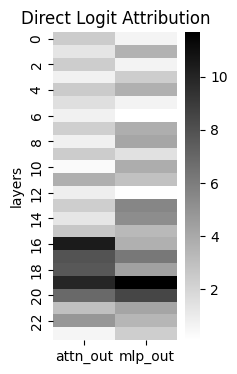

In [261]:
n_layers = model.cfg.n_layers
#hook_names = ["resid_mid", "resid_post"]
hook_names = ["attn_out", "mlp_out"]
logit_attr = torch.zeros(n_layers, len(hook_names)) ## times hook_names

for layer in range(n_layers):
    for hook_i, hook_name in enumerate(hook_names): 
        logit_attr[layer, hook_i] = residual_to_logit_diff(activs, logit_diff_dir, hook_name, layer)
        
        scores = early_decoding(activs, model, hook_name=hook_name, layer=layer)
        #token_rank, token_score = get_token_rank(scores, model, "positive")
        pred_tokens, pred_scores = topK_scores(scores, model)
        print(layer, hook_name, pred_tokens)
                
plot_heatmap(logit_attr.detach().numpy(), title='Direct Logit Attribution', cmap="binary")